In [1]:
%cd "/home/albin/skolarbete/DML_LAsegmentation"

/home/albin/skolarbete/DML_LAsegmentation


In [2]:
from scripts.train import patched_forward
from models.unet import UNet3D, NormalizationType
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from monai.networks.nets import UNETR, SwinUNETR
from scripts.dataset import TestDataset

sns.set_theme(style="whitegrid")
custom_palette = ["#D32F2F", "#1976D2", "#4CAF50"]  # Red, Blue, Light Green
sns.set_palette(custom_palette)

In [3]:
val_image_path = 'data/Task02_Heart/imagesVl'
val_label_path = 'data/Task02_Heart/labelsVl'

patch_size = (64, 128, 128)
val_dataset = TestDataset(val_image_path, val_label_path, scale_intensity=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)

In [4]:
# Load UNet3D model results
file_name_unet3d = 'unet_model_results.pkl'
with open(file_name_unet3d, 'rb') as f:
    data_unet3d = pickle.load(f)
    best_model_unet3d = UNet3D(in_channels=1, out_channels=1, features=[32, 64, 128, 256], normalization=NormalizationType.GROUP_NORM)
    best_model_unet3d.load_state_dict(data_unet3d['model_state'])
    results_unet3d = (best_model_unet3d, data_unet3d['train_metrics'], data_unet3d['val_metrics'])

best_model_unet3d, results_train_unet3d, results_val_unet3d = results_unet3d

# Load UNETR model results
file_name_unetr = 'unetR_model_results.pkl'
with open(file_name_unetr, 'rb') as f:
    data_unetr = pickle.load(f)
    best_model_unetr = UNETR(in_channels=1, out_channels=1, img_size=(64, 128, 128))
    best_model_unetr.load_state_dict(data_unetr['model_state'])
    results_unetr = (best_model_unetr, data_unetr['train_metrics'], data_unetr['val_metrics'])

best_model_unetr, results_train_unetr, results_val_unetr = results_unetr

# Load SwinUNETR model results
file_name_swinunetr = 'swinUnetR_model_results.pkl'
with open(file_name_swinunetr, 'rb') as f:
    data_swinunetr = pickle.load(f)
    best_model_swinunetr = SwinUNETR(in_channels=1, out_channels=1, img_size=(64, 128, 128))
    best_model_swinunetr.load_state_dict(data_swinunetr['model_state'])
    results_swinunetr = (best_model_swinunetr, data_swinunetr['train_metrics'], data_swinunetr['val_metrics'])

best_model_swinunetr, results_train_swinunetr, results_val_swinunetr = results_swinunetr

/home/albin/miniconda3/envs/dml/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


In [5]:
results_val_unet3d.keys()

dict_keys(['loss', 'iou', 'dice'])

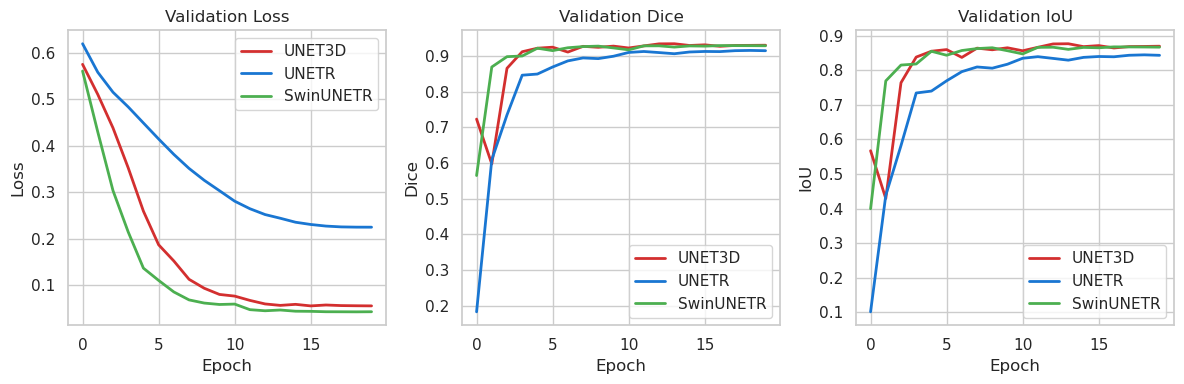

In [6]:
# Create a DataFrame for validation metrics
val_metrics_df = pd.DataFrame({
    'Epoch': range(len(results_val_unet3d['loss'])),
    'UNET3D_Loss': results_val_unet3d['loss'],
    'UNETR_Loss': results_val_unetr['loss'],
    'SwinUNETR_Loss': results_val_swinunetr['loss'],
    'UNET3D_Dice': results_val_unet3d['dice'],
    'UNETR_Dice': results_val_unetr['dice'],
    'SwinUNETR_Dice': results_val_swinunetr['dice'],
    'UNET3D_IoU': results_val_unet3d['iou'],
    'UNETR_IoU': results_val_unetr['iou'],
    'SwinUNETR_IoU': results_val_swinunetr['iou']
})

# Set up the matplotlib figure
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot validation loss
sns.lineplot(ax=axes[0], data=val_metrics_df, x='Epoch', y='UNET3D_Loss', label='UNET3D', linewidth=2)
sns.lineplot(ax=axes[0], data=val_metrics_df, x='Epoch', y='UNETR_Loss', label='UNETR', linewidth=2)
sns.lineplot(ax=axes[0], data=val_metrics_df, x='Epoch', y='SwinUNETR_Loss', label='SwinUNETR', linewidth=2)
axes[0].set_title('Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')

# Plot validation dice
sns.lineplot(ax=axes[1], data=val_metrics_df, x='Epoch', y='UNET3D_Dice', label='UNET3D', linewidth=2)
sns.lineplot(ax=axes[1], data=val_metrics_df, x='Epoch', y='UNETR_Dice', label='UNETR', linewidth=2)
sns.lineplot(ax=axes[1], data=val_metrics_df, x='Epoch', y='SwinUNETR_Dice', label='SwinUNETR', linewidth=2)
axes[1].set_title('Validation Dice')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Dice')

# Plot validation IoU
sns.lineplot(ax=axes[2], data=val_metrics_df, x='Epoch', y='UNET3D_IoU', label='UNET3D', linewidth=2)
sns.lineplot(ax=axes[2], data=val_metrics_df, x='Epoch', y='UNETR_IoU', label='UNETR', linewidth=2)
sns.lineplot(ax=axes[2], data=val_metrics_df, x='Epoch', y='SwinUNETR_IoU', label='SwinUNETR', linewidth=2)
axes[2].set_title('Validation IoU')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('IoU')

# Add grid to the plots
for ax in axes:
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

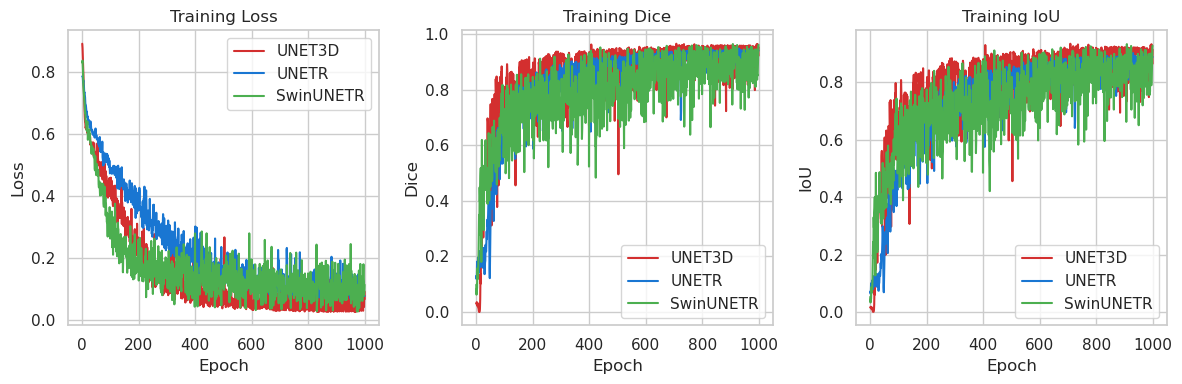

In [7]:
# Create a DataFrame for training metrics
train_metrics_df = pd.DataFrame({
    'Epoch': range(len(results_train_unet3d['loss'])),
    'UNET3D_Loss': results_train_unet3d['loss'],
    'UNETR_Loss': results_train_unetr['loss'],
    'SwinUNETR_Loss': results_train_swinunetr['loss'],
    'UNET3D_Dice': results_train_unet3d['dice'],
    'UNETR_Dice': results_train_unetr['dice'],
    'SwinUNETR_Dice': results_train_swinunetr['dice'],
    'UNET3D_IoU': results_train_unet3d['iou'],
    'UNETR_IoU': results_train_unetr['iou'],
    'SwinUNETR_IoU': results_train_swinunetr['iou']
})

# Set up the matplotlib figure
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot training loss
sns.lineplot(ax=axes[0], data=train_metrics_df, x='Epoch', y='UNET3D_Loss', label='UNET3D')
sns.lineplot(ax=axes[0], data=train_metrics_df, x='Epoch', y='UNETR_Loss', label='UNETR')
sns.lineplot(ax=axes[0], data=train_metrics_df, x='Epoch', y='SwinUNETR_Loss', label='SwinUNETR')
axes[0].set_title('Training Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')

# Plot training dice
sns.lineplot(ax=axes[1], data=train_metrics_df, x='Epoch', y='UNET3D_Dice', label='UNET3D')
sns.lineplot(ax=axes[1], data=train_metrics_df, x='Epoch', y='UNETR_Dice', label='UNETR')
sns.lineplot(ax=axes[1], data=train_metrics_df, x='Epoch', y='SwinUNETR_Dice', label='SwinUNETR')
axes[1].set_title('Training Dice')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Dice')

# Plot training IoU
sns.lineplot(ax=axes[2], data=train_metrics_df, x='Epoch', y='UNET3D_IoU', label='UNET3D')
sns.lineplot(ax=axes[2], data=train_metrics_df, x='Epoch', y='UNETR_IoU', label='UNETR')
sns.lineplot(ax=axes[2], data=train_metrics_df, x='Epoch', y='SwinUNETR_IoU', label='SwinUNETR')
axes[2].set_title('Training IoU')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('IoU')


# Add grid to the plots
for ax in axes:
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

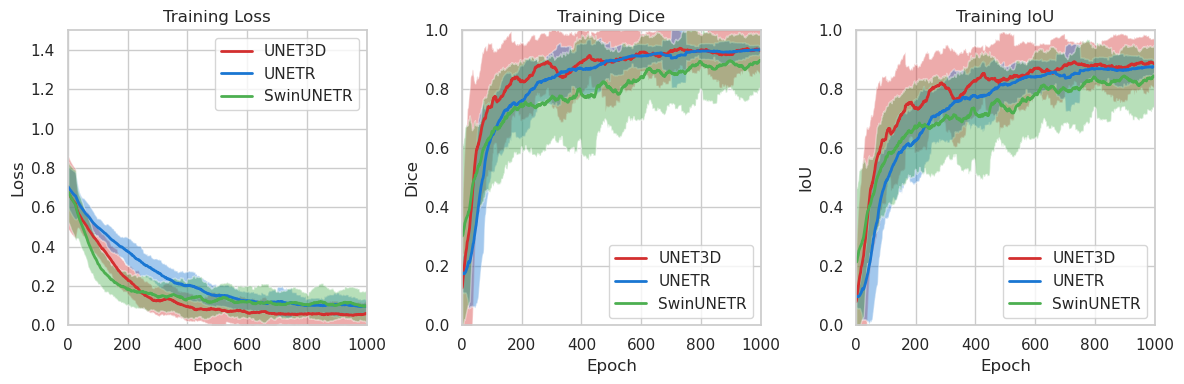

In [8]:
# Calculate rolling mean and standard deviation
window_size = 50
alpha_ = 0.4
line_width = 2  # Parameter to change the line width

train_metrics_df['UNET3D_Loss_Mean'] = train_metrics_df['UNET3D_Loss'].rolling(window=window_size, min_periods=1, center=True).mean()
train_metrics_df['UNET3D_Loss_Std'] = train_metrics_df['UNET3D_Loss'].rolling(window=window_size, min_periods=1, center=True).std()
train_metrics_df['UNETR_Loss_Mean'] = train_metrics_df['UNETR_Loss'].rolling(window=window_size, min_periods=1, center=True).mean()
train_metrics_df['UNETR_Loss_Std'] = train_metrics_df['UNETR_Loss'].rolling(window=window_size, min_periods=1, center=True).std()
train_metrics_df['SwinUNETR_Loss_Mean'] = train_metrics_df['SwinUNETR_Loss'].rolling(window=window_size, min_periods=1, center=True).mean()
train_metrics_df['SwinUNETR_Loss_Std'] = train_metrics_df['SwinUNETR_Loss'].rolling(window=window_size, min_periods=1, center=True).std()

train_metrics_df['UNET3D_Dice_Mean'] = train_metrics_df['UNET3D_Dice'].rolling(window=window_size, min_periods=1, center=True).mean()
train_metrics_df['UNET3D_Dice_Std'] = train_metrics_df['UNET3D_Dice'].rolling(window=window_size, min_periods=1, center=True).std()
train_metrics_df['UNETR_Dice_Mean'] = train_metrics_df['UNETR_Dice'].rolling(window=window_size, min_periods=1, center=True).mean()
train_metrics_df['UNETR_Dice_Std'] = train_metrics_df['UNETR_Dice'].rolling(window=window_size, min_periods=1, center=True).std()
train_metrics_df['SwinUNETR_Dice_Mean'] = train_metrics_df['SwinUNETR_Dice'].rolling(window=window_size, min_periods=1, center=True).mean()
train_metrics_df['SwinUNETR_Dice_Std'] = train_metrics_df['SwinUNETR_Dice'].rolling(window=window_size, min_periods=1, center=True).std()

train_metrics_df['UNET3D_IoU_Mean'] = train_metrics_df['UNET3D_IoU'].rolling(window=window_size, min_periods=1, center=True).mean()
train_metrics_df['UNET3D_IoU_Std'] = train_metrics_df['UNET3D_IoU'].rolling(window=window_size, min_periods=1, center=True).std()
train_metrics_df['UNETR_IoU_Mean'] = train_metrics_df['UNETR_IoU'].rolling(window=window_size, min_periods=1, center=True).mean()
train_metrics_df['UNETR_IoU_Std'] = train_metrics_df['UNETR_IoU'].rolling(window=window_size, min_periods=1, center=True).std()
train_metrics_df['SwinUNETR_IoU_Mean'] = train_metrics_df['SwinUNETR_IoU'].rolling(window=window_size, min_periods=1, center=True).mean()
train_metrics_df['SwinUNETR_IoU_Std'] = train_metrics_df['SwinUNETR_IoU'].rolling(window=window_size, min_periods=1, center=True).std()

# Set up the matplotlib figure
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot training loss with confidence intervals
axes[0].plot(train_metrics_df['Epoch'], train_metrics_df['UNET3D_Loss_Mean'], label='UNET3D', linewidth=line_width)
axes[0].fill_between(train_metrics_df['Epoch'], 
                     train_metrics_df['UNET3D_Loss_Mean'] - 1.96 * train_metrics_df['UNET3D_Loss_Std'], 
                     train_metrics_df['UNET3D_Loss_Mean'] + 1.96 * train_metrics_df['UNET3D_Loss_Std'], alpha=alpha_)
axes[0].plot(train_metrics_df['Epoch'], train_metrics_df['UNETR_Loss_Mean'], label='UNETR', linewidth=line_width)
axes[0].fill_between(train_metrics_df['Epoch'], 
                     train_metrics_df['UNETR_Loss_Mean'] - 1.96 * train_metrics_df['UNETR_Loss_Std'], 
                     train_metrics_df['UNETR_Loss_Mean'] + 1.96 * train_metrics_df['UNETR_Loss_Std'], alpha=alpha_)
axes[0].plot(train_metrics_df['Epoch'], train_metrics_df['SwinUNETR_Loss_Mean'], label='SwinUNETR', linewidth=line_width)
axes[0].fill_between(train_metrics_df['Epoch'], 
                     train_metrics_df['SwinUNETR_Loss_Mean'] - 1.96 * train_metrics_df['SwinUNETR_Loss_Std'], 
                     train_metrics_df['SwinUNETR_Loss_Mean'] + 1.96 * train_metrics_df['SwinUNETR_Loss_Std'], alpha=alpha_)
axes[0].set_title('Training Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')

# Plot training dice with confidence intervals
axes[1].plot(train_metrics_df['Epoch'], train_metrics_df['UNET3D_Dice_Mean'], label='UNET3D', linewidth=line_width)
axes[1].fill_between(train_metrics_df['Epoch'], 
                     train_metrics_df['UNET3D_Dice_Mean'] - 1.96 * train_metrics_df['UNET3D_Dice_Std'], 
                     train_metrics_df['UNET3D_Dice_Mean'] + 1.96 * train_metrics_df['UNET3D_Dice_Std'], alpha=alpha_)
axes[1].plot(train_metrics_df['Epoch'], train_metrics_df['UNETR_Dice_Mean'], label='UNETR', linewidth=line_width)
axes[1].fill_between(train_metrics_df['Epoch'], 
                     train_metrics_df['UNETR_Dice_Mean'] - 1.96 * train_metrics_df['UNETR_Dice_Std'], 
                     train_metrics_df['UNETR_Dice_Mean'] + 1.96 * train_metrics_df['UNETR_Dice_Std'], alpha=alpha_)
axes[1].plot(train_metrics_df['Epoch'], train_metrics_df['SwinUNETR_Dice_Mean'], label='SwinUNETR', linewidth=line_width)
axes[1].fill_between(train_metrics_df['Epoch'], 
                     train_metrics_df['SwinUNETR_Dice_Mean'] - 1.96 * train_metrics_df['SwinUNETR_Dice_Std'], 
                     train_metrics_df['SwinUNETR_Dice_Mean'] + 1.96 * train_metrics_df['SwinUNETR_Dice_Std'], alpha=alpha_)
axes[1].set_title('Training Dice')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Dice')

# Plot training IoU with confidence intervals
axes[2].plot(train_metrics_df['Epoch'], train_metrics_df['UNET3D_IoU_Mean'], label='UNET3D', linewidth=line_width)
axes[2].fill_between(train_metrics_df['Epoch'], 
                     train_metrics_df['UNET3D_IoU_Mean'] - 1.96 * train_metrics_df['UNET3D_IoU_Std'], 
                     train_metrics_df['UNET3D_IoU_Mean'] + 1.96 * train_metrics_df['UNET3D_IoU_Std'], alpha=alpha_)
axes[2].plot(train_metrics_df['Epoch'], train_metrics_df['UNETR_IoU_Mean'], label='UNETR', linewidth=line_width)
axes[2].fill_between(train_metrics_df['Epoch'], 
                     train_metrics_df['UNETR_IoU_Mean'] - 1.96 * train_metrics_df['UNETR_IoU_Std'], 
                     train_metrics_df['UNETR_IoU_Mean'] + 1.96 * train_metrics_df['UNETR_IoU_Std'], alpha=alpha_)
axes[2].plot(train_metrics_df['Epoch'], train_metrics_df['SwinUNETR_IoU_Mean'], label='SwinUNETR', linewidth=line_width)
axes[2].fill_between(train_metrics_df['Epoch'], 
                     train_metrics_df['SwinUNETR_IoU_Mean'] - 1.96 * train_metrics_df['SwinUNETR_IoU_Std'], 
                     train_metrics_df['SwinUNETR_IoU_Mean'] + 1.96 * train_metrics_df['SwinUNETR_IoU_Std'], alpha=alpha_)
axes[2].set_title('Training IoU')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('IoU')

# Set seaborn theme
sns.set_theme(style="whitegrid")

# Add grid to the plots
for ax in axes:
    ax.grid(True)
    ax.legend()
    ax.set_xlim(0, 1000)
    if ax == axes[0]:
        ax.set_ylim(0, 1.5)
    else:
        ax.set_ylim(0, 1)

# Adjust layout
plt.tight_layout()
plt.show()

In [9]:
test_image_path = 'data/Task02_Heart/imagesVl'
test_label_path = 'data/Task02_Heart/labelsVl'

device = 'cuda'
test_dataset = TestDataset(test_image_path, test_label_path, scale_intensity=True)
image_idx = 0
image, label = test_dataset[image_idx]
image = image.unsqueeze(0)

In [10]:
image = image.to(device)
best_model_unet3d = best_model_unet3d.to(device)
best_model_unetr = best_model_unetr.to(device)
best_model_swinunetr = best_model_swinunetr.to(device)

with torch.no_grad():
    pred_unet = patched_forward(best_model_unet3d, image, patch_size, overlap=0.5, device=device).cpu()
    pred_unetr = patched_forward(best_model_unetr, image, patch_size, overlap=0.5, device=device).cpu()
    pred_swinunetr = patched_forward(best_model_swinunetr, image, patch_size, overlap=0.5, device=device).cpu()

/home/albin/miniconda3/envs/dml/lib/python3.11/site-packages/torch/_tensor.py:1443: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  ret = func(*args, **kwargs)


In [11]:
image = image.cpu().squeeze().numpy()
label = label.squeeze().numpy()
pred_unet = torch.sigmoid(pred_unet).squeeze().numpy()
pred_unetr = torch.sigmoid(pred_unetr).squeeze().numpy()
pred_swinunetr = torch.sigmoid(pred_swinunetr).squeeze().numpy()

In [12]:
print(image.shape, label.shape, pred_unet.shape, pred_unetr.shape, pred_swinunetr.shape)

(120, 320, 320) (120, 320, 320) (120, 320, 320) (120, 320, 320) (120, 320, 320)


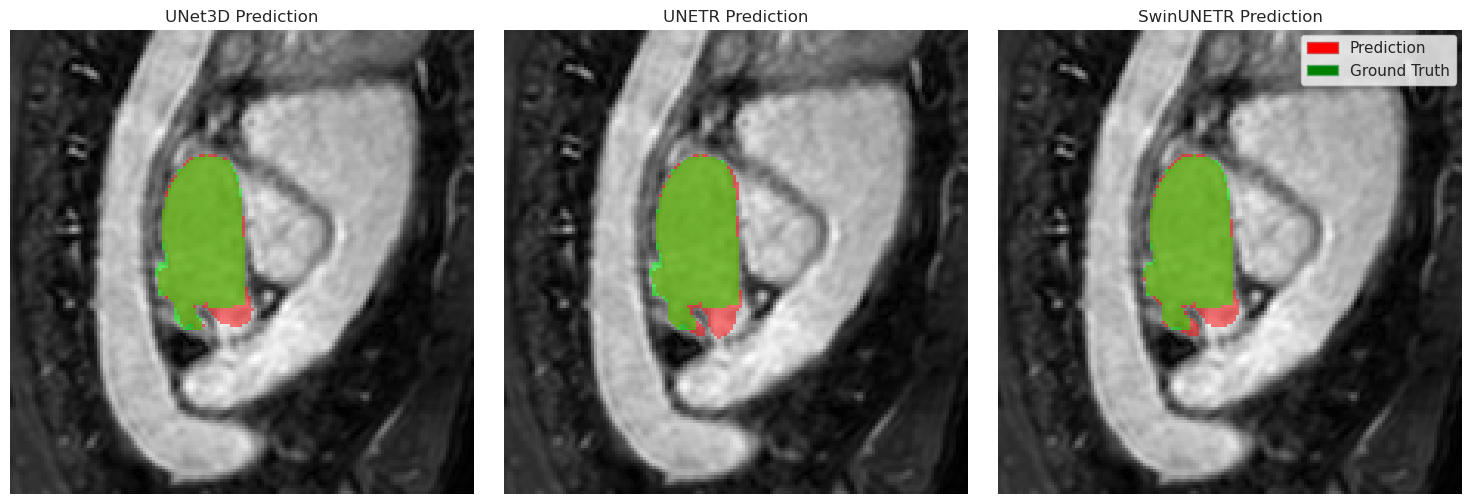

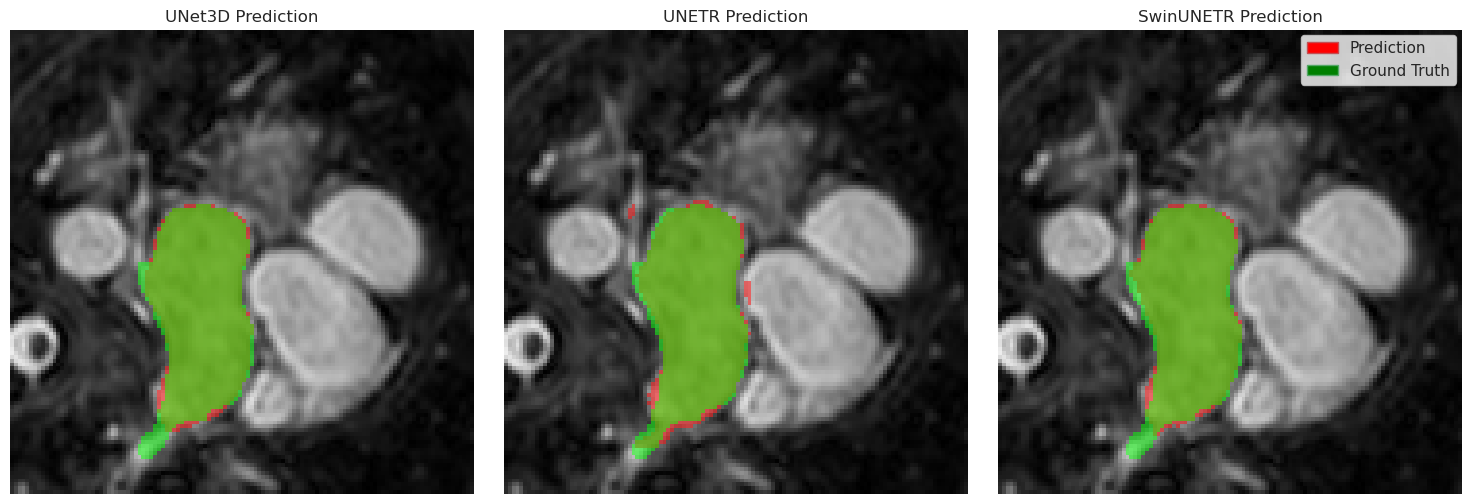

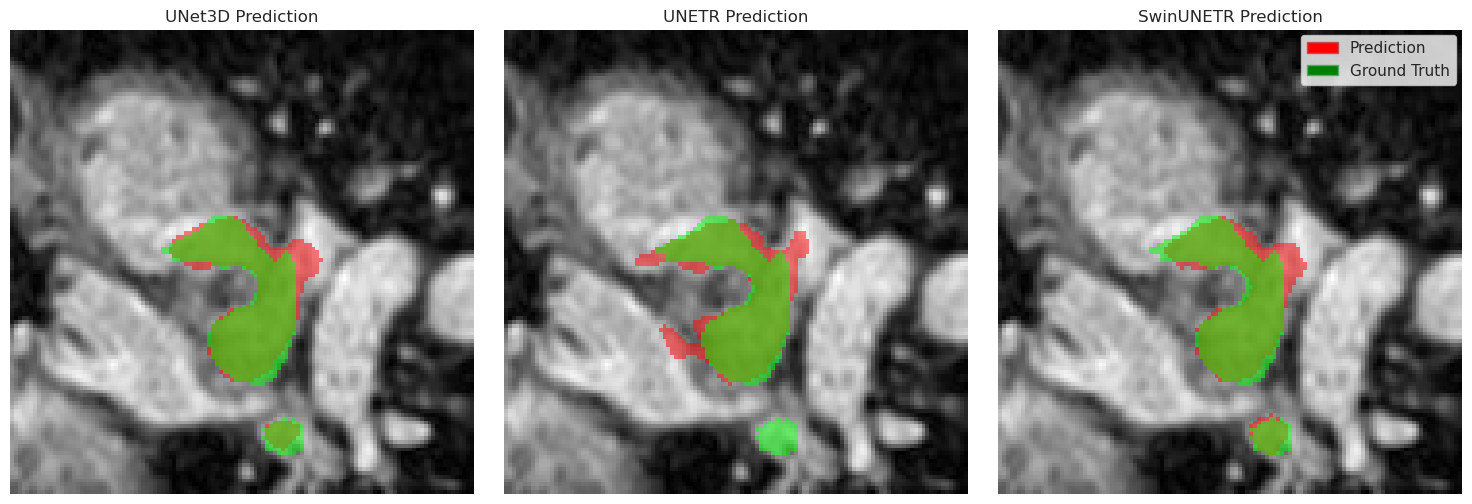

In [30]:
from matplotlib.patches import Patch

def process_slice(slice_index, slice_dim=0, center_crop=(150, 150)):
    # Function to crop the center of an image
    def crop_center(img, cropx, cropy):
        y, x = img.shape
        startx = x // 2 - (cropx // 2)
        starty = y // 2 - (cropy // 2)
        return img[starty:starty + cropy, startx:startx + cropx]

    # Select the appropriate slice based on the slice_dim
    if slice_dim == 0:
        image_slice = crop_center(image[slice_index], center_crop[0], center_crop[1])
        pred_unet_slice = crop_center(pred_unet[slice_index], center_crop[0], center_crop[1])
        pred_unetr_slice = crop_center(pred_unetr[slice_index], center_crop[0], center_crop[1])
        pred_swinunetr_slice = crop_center(pred_swinunetr[slice_index], center_crop[0], center_crop[1])
        label_slice = crop_center(label[slice_index], center_crop[0], center_crop[1])
    elif slice_dim == 1:
        image_slice = crop_center(image[:, slice_index, :], center_crop[0], center_crop[1])
        pred_unet_slice = crop_center(pred_unet[:, slice_index, :], center_crop[0], center_crop[1])
        pred_unetr_slice = crop_center(pred_unetr[:, slice_index, :], center_crop[0], center_crop[1])
        pred_swinunetr_slice = crop_center(pred_swinunetr[:, slice_index, :], center_crop[0], center_crop[1])
        label_slice = crop_center(label[:, slice_index, :], center_crop[0], center_crop[1])
    elif slice_dim == 2:
        image_slice = crop_center(image[:, :, slice_index], center_crop[0], center_crop[1])
        pred_unet_slice = crop_center(pred_unet[:, :, slice_index], center_crop[0], center_crop[1])
        pred_unetr_slice = crop_center(pred_unetr[:, :, slice_index], center_crop[0], center_crop[1])
        pred_swinunetr_slice = crop_center(pred_swinunetr[:, :, slice_index], center_crop[0], center_crop[1])
        label_slice = crop_center(label[:, :, slice_index], center_crop[0], center_crop[1])

    # Binarize predictions
    pred_unet_slice = (pred_unet_slice > 0.5).astype(np.float32)
    pred_unetr_slice = (pred_unetr_slice > 0.5).astype(np.float32)
    pred_swinunetr_slice = (pred_swinunetr_slice > 0.5).astype(np.float32)

    # Normalize image slice for visualization (if needed)
    image_slice = (image_slice - image_slice.min()) / (image_slice.max() - image_slice.min())

    # Create an RGB image from the grayscale slice
    image_rgb = np.stack([image_slice]*3, axis=-1)

    # Create solid colors for the prediction and label overlays
    red_overlay = np.zeros_like(image_rgb)
    red_overlay[..., 0] = 1  # Red color for prediction

    green_overlay = np.zeros_like(image_rgb)
    green_overlay[..., 1] = 1  # Green color for label

    # Create the prediction and label masks (expanding dims for compatibility)
    pred_unet_mask = np.expand_dims(pred_unet_slice, axis=-1)
    pred_unetr_mask = np.expand_dims(pred_unetr_slice, axis=-1)
    pred_swinunetr_mask = np.expand_dims(pred_swinunetr_slice, axis=-1)
    label_mask = np.expand_dims(label_slice, axis=-1)

    # Set the opacity for the overlays (50% opacity)
    opacity = 0.5

    # Function to create overlay image
    def create_overlay(image_rgb, pred_mask, label_mask, opacity):
        overlay_image = image_rgb * (1 - pred_mask * opacity) + red_overlay * pred_mask * opacity
        overlay_image = overlay_image * (1 - label_mask * opacity) + green_overlay * label_mask * opacity
        return overlay_image

    # Create overlay images for each prediction
    overlay_unet = create_overlay(image_rgb, pred_unet_mask, label_mask, opacity)
    overlay_unetr = create_overlay(image_rgb, pred_unetr_mask, label_mask, opacity)
    overlay_swinunetr = create_overlay(image_rgb, pred_swinunetr_mask, label_mask, opacity)

    # Plot the resulting images with the 50% opacity overlays
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(overlay_unet)
    axes[0].set_title('UNet3D Prediction')
    axes[0].axis('off')

    axes[1].imshow(overlay_unetr)
    axes[1].set_title('UNETR Prediction')
    axes[1].axis('off')

    axes[2].imshow(overlay_swinunetr)
    axes[2].set_title('SwinUNETR Prediction')
    axes[2].axis('off')

    # Add legend
    legend_elements = [Patch(facecolor='red', edgecolor='r', label='Prediction'),
                       Patch(facecolor='green', edgecolor='g', label='Ground Truth')]
    fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.985, 0.97))

    plt.tight_layout()
    plt.show()

process_slice(slice_index=60, slice_dim=0, center_crop=(150, 150))
process_slice(slice_index=320//2, slice_dim=1, center_crop=(120, 120))
process_slice(slice_index=320//2, slice_dim=2, center_crop=(120, 120))

In [ ]:
import plotly.graph_objects as go

# Create a 3D scatter plot for the binary label array
def visualize_3d_label(label):
    # Get the coordinates of the non-zero elements in the label array
    x, y, z = label.nonzero()

    # Create a 3D scatter plot
    fig = go.Figure(data=[go.Scatter3d(
        x=x, y=y, z=z,
        mode='markers',
        marker=dict(
            size=2,
            color='red',  # Color of the points
            opacity=0.05  # Adjusted opacity for more transparency
        )
    )])

    # Set plot title and axis labels
    fig.update_layout(
        title='3D Visualization of Label',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        )
    )

    # Show the plot
    fig.show()
#    fig.write_html("3d_plot.html")


# Visualize the label
visualize_3d_label(label)

In [ ]:
# Create a 3D scatter plot for the binary label array and UNET3D prediction with update menu
def visualize_3d_label_and_prediction(label, pred_unet):
    # Get the coordinates of the non-zero elements in the label array
    x_label, y_label, z_label = label.nonzero()
    x_pred_unet, y_pred_unet, z_pred_unet = np.where(pred_unet > 0.5, 1, 0).nonzero()

    # Create a 3D scatter plot
    fig = go.Figure()

    # Add label points
    fig.add_trace(go.Scatter3d(
        x=x_label, y=y_label, z=z_label,
        mode='markers',
        marker=dict(
            size=2,
            color='red',  # Color of the points
            opacity=0.1  # Adjusted opacity for more transparency
        ),
        name='Label'
    ))

    # Add UNET3D prediction points
    fig.add_trace(go.Scatter3d(
        x=x_pred_unet+0.5, y=y_pred_unet+0.5, z=z_pred_unet+0.5,
        mode='markers',
        marker=dict(
            size=2,
            color='blue',  # Color of the points
            opacity=0.1 # Adjusted opacity for more transparency
        ),
        name='UNET3D Prediction'
    ))

    # Add update menu with checkboxes
    fig.update_layout(
        updatemenus=[
            dict(
                type="buttons",
                direction="left",
                buttons=list([
                    dict(
                        args=["visible", [True, True]],
                        label="Show All",
                        method="restyle"
                    ),
                    dict(
                        args=["visible", [True, False]],
                        label="Show Label Only",
                        method="restyle"
                    ),
                    dict(
                        args=["visible", [False, True]],
                        label="Show UNET3D Prediction Only",
                        method="restyle"
                    ),
                ]),
                pad={"r": 10, "t": 10},
                showactive=True,
                x=0.1,
                xanchor="left",
                y=1.1,
                yanchor="top"
            ),
        ]
    )

    # Set plot title and axis labels
    fig.update_layout(
        title='3D Visualization of Label and UNET3D Prediction',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        )
    )

    # Show the plot
    fig.show()

# Visualize the label and UNET3D prediction
visualize_3d_label_and_prediction(label, pred_unet)